# Adversary Noise
by Gaetano Bonofiglio, Veronica Iovinella

## Introduction
We previously created various Convolutional Neural Networks using $TensorFlow$ with various degrees of success. In this notebook we'll find a so-called "**adversarial example**" for a state-of-the-art neural network (**Inception Model V3**) that will cause a mis-classification of an input image of any class. The *adversary noise* is added to a correctly classified picture and can't be perceived by a human eye, but it's catastrophic for the classifier.

Usually to win against an adversary example it's needed to re-train a CNN in a never-ending cycle (it's always possible to find a new adversary example for the newly trained CNN, expecially if it is open source). We will instead explore a different method for solving this issue that doesn't involve re-training the network and should be able to win even against ad-hoc noises. 

## Flowchart
To find the adversary examples, we follow the flowchart below. 
We start from an image given to Inception Model, we take the output of the unscaled softmax layer and give it as an input to a cross-entropy loss-function, together with a target class. This new function then calculates the cross-entropy to generate a noise that, added to the original image, gets an output that is closer, iteration by iteration, to the target class. 

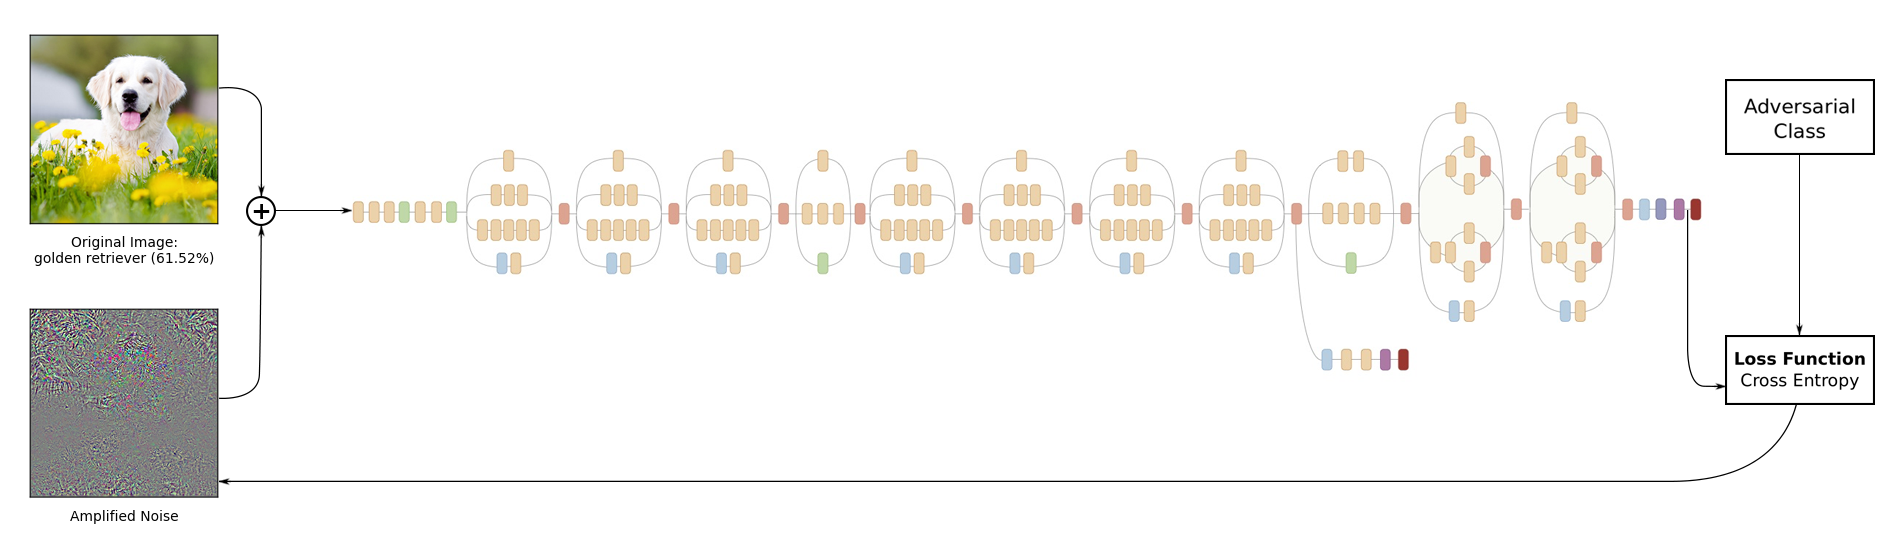

In [1]:
from IPython.display import Image
Image('images/06_flowchart.png')

## Imports

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
from IPython.display import display

from adversary import Adversary
adv = Adversary()

import inception

tf.__version__

'0.11.head'

In [3]:
inception.maybe_download()

Data has apparently already been downloaded and unpacked.


In [4]:
# Load the Inception model so it is ready for classifying images.
model = inception.Inception()
# Helper-function for classifying and plotting images
def classify(image_path):
    display(Image(image_path))
    pred = model.classify(image_path=image_path)
    model.print_scores(pred=pred, k=10, only_first_name=True)
# Image path for the example picture to classify
image_path = os.path.join(inception.data_dir, 'cropped_panda.jpg')

We now try to classify the image of a panda to see if everything is working fine.

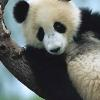

88.49% : giant panda
 0.88% : indri
 0.32% : lesser panda
 0.15% : custard apple
 0.13% : earthstar
 0.09% : sea urchin
 0.06% : gibbon
 0.05% : forklift
 0.05% : digital watch
 0.05% : go-kart


In [5]:
classify(image_path)

### Get Input and Output for the Inception Model
We need to get a reference to the input tensor for the Inception model. This is because the input tensor is for the resized image, and we want to add noise to the resized image and feed the result back into the graph, in order to be sure that the noise is not processed further by the resizing algorithm.

We also need to reference the unscaled output of the softmax-classifier for the Inception model (often called 'logits'). The logits are necessary because we will add a new loss-function to the graph, which requires these unscaled outputs.

In [6]:
resized_image = model.resized_image

# Reference to the output of the softmax-classifier for the Inception model
y_pred = model.y_pred
# Reference the unscaled output of the softmax-classifier - logits
y_logits = model.y_logits

### New loss-function
Here it is the new loss-function. We also need the gradient of this loss-function with regard to the input image. 

In [7]:
with model.graph.as_default():
    # Add a placeholder variable for the target class-number
    # This will be set to e.g. 300 for the 'bookcase' class
    pl_cls_target = tf.placeholder(dtype=tf.int32)

    # New cross-entropy loss-function
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=y_logits, labels=[pl_cls_target])

    gradient = tf.gradients(loss, resized_image)

## TensorFlow Session

In [8]:
session = tf.Session(graph=model.graph)

## Finding Adversary Noise
This function finds the noise that must be added to the given input image to be classified as the desired target-class, so to be mis-classified.

This is obtained by doing an optimization with gradient descent. The noise is initialized to zero and then iteratively updated using the gradient of the loss-function, bringing the classification closer and closer to the target-class. The optimization terminates when the target-classification is reached with the required score (by default 99%), or when the max number of iterations have been performed (by default 100).

At the end the original image, the image with the added noise and the noise itself are plotted.

In [9]:
def adversary_example(image_path, cls_target,
                      noise_limit=3.0, required_score=0.99):
    adv.adversary_example(session, y_pred, resized_image, model, gradient, pl_cls_target, 
                          image_path, cls_target,
                          noise_limit, required_score)

## Results
As shown below, we can see from some examples that a few iterations are sufficient to calculate the noise, resulting in a misclassification of arbitrary score (in this case 99%).

Iteration: 0
Source score:  61.52%, class-number:  125, class-name: golden retriever
Target score:   0.01%, class-number:  220, class-name: umbrella
Gradient min: -0.001715, max:  0.001959, stepsize:   3572.60

Iteration: 1
Source score:   0.48%, class-number:  125, class-name: golden retriever
Target score:   0.04%, class-number:  220, class-name: umbrella
Gradient min: -0.003461, max:  0.003100, stepsize:   2022.35

Iteration: 2
Source score:   4.10%, class-number:  125, class-name: golden retriever
Target score:   0.36%, class-number:  220, class-name: umbrella
Gradient min: -0.004149, max:  0.002682, stepsize:   1687.32

Iteration: 3
Source score:   2.75%, class-number:  125, class-name: golden retriever
Target score:  13.21%, class-number:  220, class-name: umbrella
Gradient min: -0.005081, max:  0.004361, stepsize:   1377.74

Iteration: 4
Source score:   3.42%, class-number:  125, class-name: golden retriever
Target score:  57.37%, class-number:  220, class-name: umbrella
Gradien

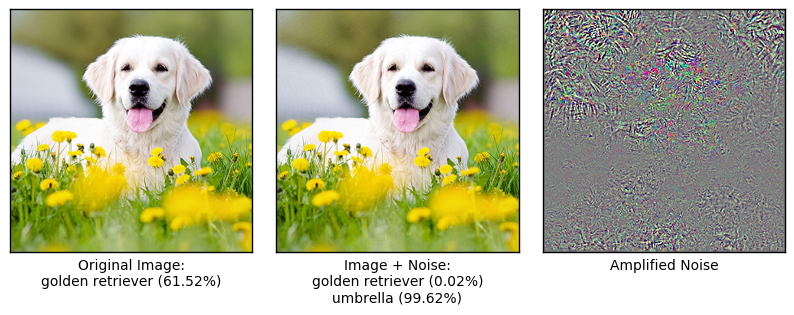

Noise min: -3.000, max: 3.000, mean: 0.001, std: 0.743


In [10]:
image_path = "imagesForClassification/dog.jpg"
adversary_example(image_path=image_path, cls_target=220)

Iteration: 0
Source score:  47.47%, class-number:   10, class-name: Persian cat
Target score:   0.06%, class-number:  535, class-name: sunglasses
Gradient min: -0.001900, max:  0.002446, stepsize:   2861.93

Iteration: 1
Source score:   0.41%, class-number:   10, class-name: Persian cat
Target score:   0.42%, class-number:  535, class-name: sunglasses
Gradient min: -0.001881, max:  0.001840, stepsize:   3720.97

Iteration: 2
Source score:   0.72%, class-number:   10, class-name: Persian cat
Target score:   1.83%, class-number:  535, class-name: sunglasses
Gradient min: -0.002028, max:  0.001701, stepsize:   3452.34

Iteration: 3
Source score:   0.44%, class-number:   10, class-name: Persian cat
Target score:  18.21%, class-number:  535, class-name: sunglasses
Gradient min: -0.002366, max:  0.002182, stepsize:   2958.83

Iteration: 4
Source score:   0.08%, class-number:   10, class-name: Persian cat
Target score:  43.49%, class-number:  535, class-name: sunglasses
Gradient min: -0.00344

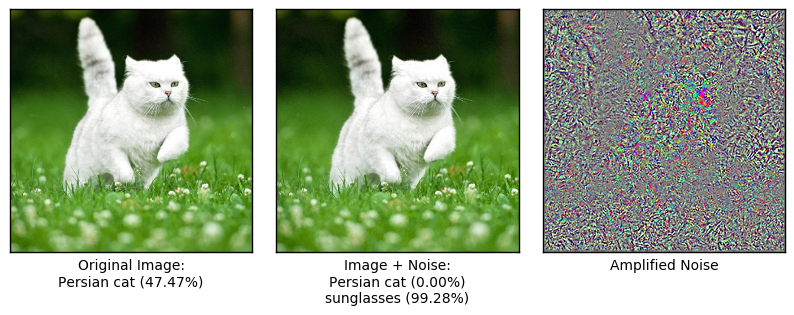

Noise min: -3.000, max: 3.000, mean: 0.000, std: 1.070


In [11]:
image_path = "imagesForClassification/cat.jpg"
adversary_example(image_path=image_path, cls_target=535)

Iteration: 0
Source score:  87.96%, class-number:  318, class-name: Granny Smith
Target score:   0.00%, class-number:   22, class-name: killer whale
Gradient min: -0.001250, max:  0.001410, stepsize:   4963.31

Iteration: 1
Source score:   1.68%, class-number:  318, class-name: Granny Smith
Target score:   0.04%, class-number:   22, class-name: killer whale
Gradient min: -0.001285, max:  0.001185, stepsize:   5445.68

Iteration: 2
Source score:  13.32%, class-number:  318, class-name: Granny Smith
Target score:   0.04%, class-number:   22, class-name: killer whale
Gradient min: -0.001314, max:  0.000983, stepsize:   5328.46

Iteration: 3
Source score:  11.44%, class-number:  318, class-name: Granny Smith
Target score:   0.12%, class-number:   22, class-name: killer whale
Gradient min: -0.001152, max:  0.000819, stepsize:   6074.28

Iteration: 4
Source score:   1.63%, class-number:  318, class-name: Granny Smith
Target score:   0.25%, class-number:   22, class-name: killer whale
Gradien

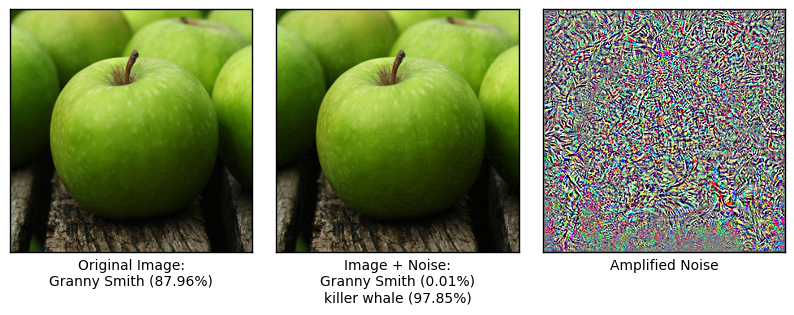

Noise min: -3.000, max: 3.000, mean: 0.006, std: 1.506


In [12]:
image_path = "imagesForClassification/grannySmith.jpg"
adversary_example(image_path=image_path, cls_target=22, noise_limit=3.0, required_score=0.95)

## Possible solution to Adversary Noise
A possible solution for adversary noise is to classify the same image in different reduced sizes and crops, or even different JPEG compressions. This is because the adversary noise is comparable to white noise, that becomes more like an uniform color after downsizing. 

Higher JPG compression is also a possible solution, because that kind of lossy compression is made to preserve only what the human eye can see. 

### Original image
For a better comparison, the original picture is here downscaled from 600x600 to 299x299 pixels to reflect the size of the one with the adversary noise. This causes the "golden retriever" class to go from 61% to 58% probability.

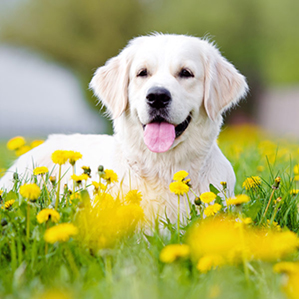

58.80% : golden retriever
 8.78% : rapeseed
 7.04% : Labrador retriever
 3.17% : Great Pyrenees
 1.44% : kuvasz
 0.65% : tennis ball
 0.55% : clumber
 0.52% : flat-coated retriever
 0.29% : Leonberg
 0.25% : doormat


In [13]:
classify("adversaryImages/golden-retriever_original_299x299.jpg")

### Noisy image
This is the original image with the adversary noise applied. Please note that the misclassification is already lowered from 99.6% to 98.7% because of the JPEG compression when converting the nparray to a jpg file).

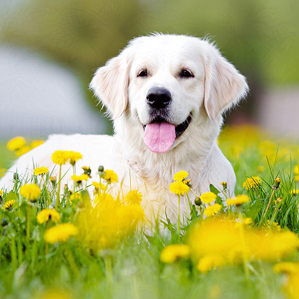

98.73% : umbrella
 0.24% : Great Pyrenees
 0.06% : golden retriever
 0.05% : kuvasz
 0.02% : flat-coated retriever
 0.01% : Labrador retriever
 0.01% : rapeseed
 0.01% : Leonberg
 0.01% : clumber
 0.01% : water jug


In [14]:
classify("adversaryImages/golden-retriever.jpg")

### Higher JPEG compression
As the compression gets higher, the adversary noise is lost, since JPEG compression is made to preserve only details that are relevant to the human eye. The class "golden retriever" went from 58% to 42%, but it's acceptable since the second class becomes "Labrador retriever" with 22%, that is a very similar breed (was only 7% in the original image). 

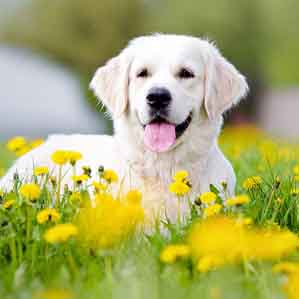

42.20% : golden retriever
22.71% : Labrador retriever
 9.49% : kuvasz
 0.91% : rapeseed
 0.74% : curly-coated retriever
 0.69% : flat-coated retriever
 0.64% : English setter
 0.60% : tennis ball
 0.60% : clumber
 0.34% : Great Pyrenees


In [15]:
classify("adversaryImages/golden-retriever_compressed.jpg")

### 50% scale (bicubic)
As said above, the adversary noise is usually comparable to white noise. White noise has a tendency to become like an uniform color or a blurred pattern when downsized. However this method is less reliable since downscaling every input may reduce the precision of the classifier more than the JPEG compression. Please note that this image has the same JPEG compression as the original noisy one (almost uncompressed).

In this case the class "golden retriever" is again the first one, from the original 58% to 55%, with overall a similar ranking in the other classes.

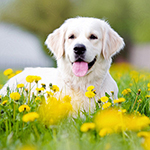

55.21% : golden retriever
10.43% : rapeseed
 8.56% : Labrador retriever
 4.87% : kuvasz
 2.07% : clumber
 1.13% : flat-coated retriever
 1.03% : curly-coated retriever
 0.40% : tennis ball
 0.39% : Great Pyrenees
 0.20% : Chesapeake Bay retriever


In [16]:
classify("adversaryImages/golden-retriever_downscaled.jpg")

### 50% scale + 199.5% scale (bicubic)
This method mixes the information loss caused by downscaling a picture, with the information gain and smoothing of the bicubic upscaling. 
The results are also acceptable, since it only went from 58% to 53%, with "kuvasz" and "Labrador retriever", both similar dog breeds, surpassing "rapeseed" (the yellow flowers) in the ranking. 

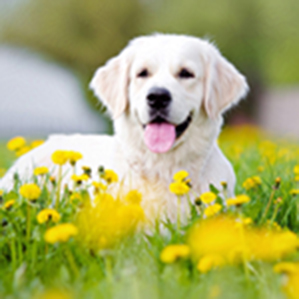

53.71% : golden retriever
 9.21% : kuvasz
 7.77% : Labrador retriever
 6.80% : rapeseed
 1.22% : curly-coated retriever
 1.15% : clumber
 1.02% : flat-coated retriever
 0.49% : tennis ball
 0.44% : Great Pyrenees
 0.22% : Chesapeake Bay retriever


In [17]:
classify("adversaryImages/golden-retriever_down-up-scaled.jpg")

In all the methods seen above, a small compression or some scaling tricks are more then enough to make the adversary noise disappear completely from the top classes of the output (the class "umbrella" has a probability lower then 0.2% after the tweaks). 

## Close TensorFlow Session

In [ ]:
model.close()
session.close()

## Conclusion
In this notebook we analized a very critical problem for CNNs, and investigated possible solutions. The adversary noises are quite easy to calculate, and can cause a mis-classification with almost 100% accuracy.
The solution proposed are based on compression algorithms and scaling, which would mostly smooth the noise.
We tried processing the image with high JPEG compression, bicubic interpolation at 50% and bicubic interpolation at 50% and then again at 199.5%. 
The intuition behind the JPEG compression is that the adversary noise is mostly invisible to the human eye, and that the compression is used exactly to smooth every element not so relevant to the human vision. This made us wonder if it would be effective in eliminating the interference of such noise.
On the other hand, while the adversary noise is not white noise, it still blends on itself when interpolated and even more when downscaled, so we tried to downscale the image. We had even better resuls when also upscaling the image with bicubic interpolation, in order to recover some features and to go back to the ideal picture size, the same one used during the training.

Every experiment resulted in a good classification, and most importantly the complete disappearance of the adversary class (umbrella), and thus we can conclude that the compression/scaling is a good approach to solve the adversary noise problem. 

A downside of this solution is that applying a preprocessing to every image to classify might be heavy (but still better that retraining the CNN), and that we can lose some important details from the original images, lowering the classification accuracy in some cases.

In the next notebook we will study DeepDream, a computer vision program created by Google to better understand what happens between convolutional layers.